In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

from IPython.display import display


import warnings
import pickle

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def read_json_df(path):
    json = pd.read_json(r"{}".format(path))
    df_apartments = json[['id', 'floor', 'beds', 'price', 'size_m2']]
    
    df_tags = json.explode('tags').dropna(subset=['tags'])
    df_tags['tag_category'] = df_tags['tags'].apply(lambda x: x['tag_category'])
    df_tags['tag_value'] = df_tags['tags'].apply(lambda x: x['tag_value'])
    
    df_tags = df_tags.pivot_table(index='id',
                                  columns='tag_category', 
                                  values='tag_value', 
                                  aggfunc='first').reset_index()
    
    df = df_apartments.merge(df_tags, on='id', how='left')
    return df


df = read_json_df("for_rent_apartments.json")
df.head()

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,ieVNwuOX98B,2,3,10000,70,2.0,1.0,1.0,1.0,2.0,2.0,5.0
1,kRYP2kIMVho,3,5,12300,120,1.0,5.0,2.0,1.0,1.0,1.0,1.0
2,bk4LlhcSrQI,14,4,13000,170,1.0,3.0,4.0,1.0,1.0,1.0,5.0
3,cTRw7SDpf1E,0,3,4800,85,3.0,5.0,3.0,3.0,2.0,2.0,2.0
4,N0okrcZMZ88,1,1,3200,19,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [3]:
features = df.drop("id",axis=1).columns
new_df = df[features]

In [4]:
new_df.columns

Index(['floor', 'beds', 'price', 'size_m2', 'families', 'light_trail', 'parks',
       'quiet_street', 'religious', 'school', 'secular'],
      dtype='object')

In [5]:
new_df.head()

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,2,3,10000,70,2.0,1.0,1.0,1.0,2.0,2.0,5.0
1,3,5,12300,120,1.0,5.0,2.0,1.0,1.0,1.0,1.0
2,14,4,13000,170,1.0,3.0,4.0,1.0,1.0,1.0,5.0
3,0,3,4800,85,3.0,5.0,3.0,3.0,2.0,2.0,2.0
4,1,1,3200,19,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [6]:
scaler = pickle.load(open("for_rent_preprocessor.pkl","rb"))

In [7]:
scaler

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['floor', 'beds', 'price', 'size_m2', 'families', 'light_trail', 'parks',
       'quiet_street', 'religious', 'school', 'secular'],
      dtype='object'))])

In [8]:
scaled_df = scaler.transform(new_df)

In [9]:
scaled_df

array([[-0.24360446, -0.17568178, -0.03773616, ..., -0.59701748,
        -0.27776431,  1.15964766],
       [-0.02920649,  1.21112129, -0.02777266, ..., -1.18385129,
        -0.90178647, -1.27532192],
       [ 2.32917119,  0.51771976, -0.02474029, ..., -1.18385129,
        -0.90178647,  1.15964766],
       ...,
       [-0.45800243, -0.17568178, -0.0645943 , ...,  1.16348396,
        -0.27776431, -0.66657952],
       [ 1.90037525, -0.17568178, -0.05722997, ...,  1.16348396,
         1.59430216,  1.15964766],
       [-0.24360446, -1.56248485, -0.07282502, ...,  1.16348396,
         0.97028001,  0.55090526]])

In [10]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km.algorithm = "lloyd"
    km = km.fit(scaled_df)
    sum_of_squared_distances.append(km.inertia_)

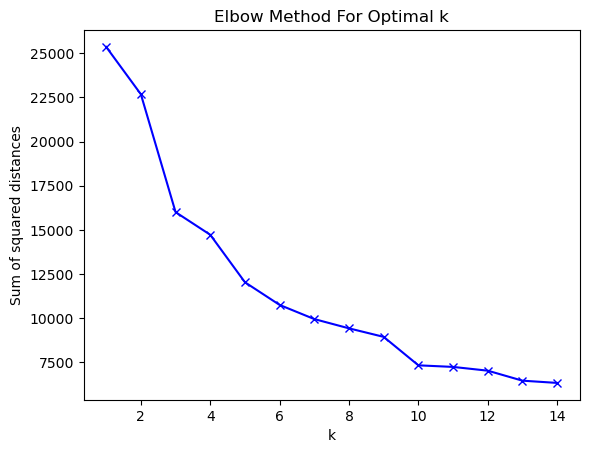

In [11]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

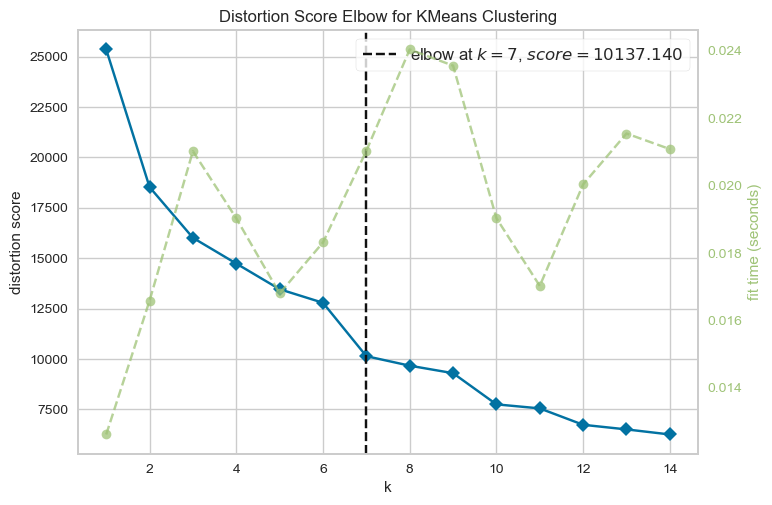

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
km.algorithm = "lloyd"
visualizer = KElbowVisualizer(km, k=(1,15))
 
visualizer.fit(scaled_df)
visualizer.show()

In [13]:
optimal_clusters = visualizer.elbow_value_

In [14]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_df)

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.algorithm = "lloyd"
kmeans.fit(tsne_results)
labels = kmeans.labels_

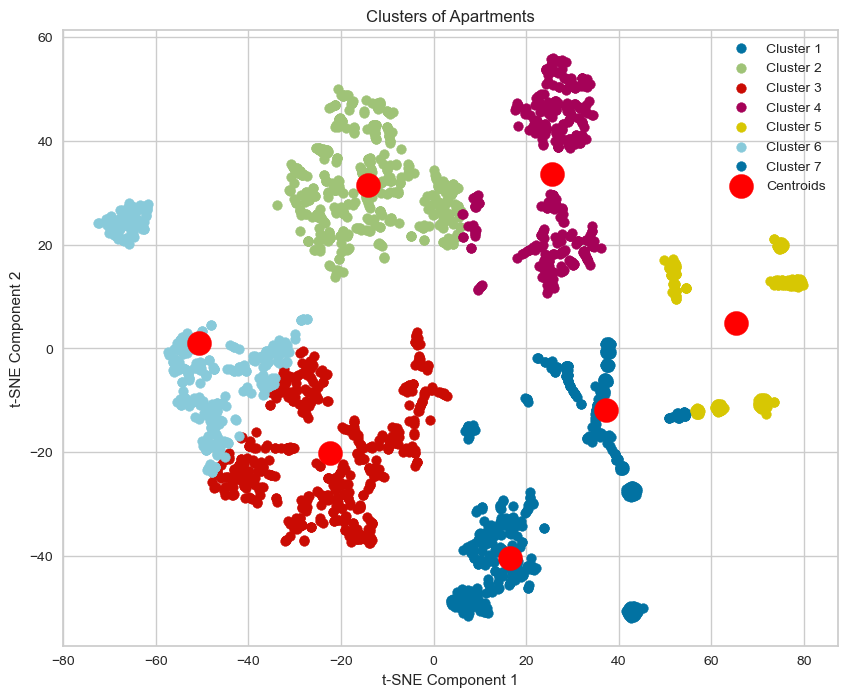

In [15]:
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [16]:
with open("for_rent_clustering_model.pkl", "wb") as f:
    pickle.dump({"tsne":tsne, "kmeans":kmeans}, f)

### Testing Prediction For New Apartment

In [17]:
first_apartment_id = df.iloc[200].id
first_apartment = df[df.id == first_apartment_id]

In [18]:
first_apartment

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
200,gZshjfDCEci,0,1,3200,16,3.0,2.0,1.0,1.0,5.0,1.0,1.0


In [19]:
scaled_apartment = scaler.transform(first_apartment)

In [20]:
combined_data = np.vstack([scaled_df, scaled_apartment])
tsne_combined = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_combined_results = tsne_combined.fit_transform(combined_data)

# Extract the t-SNE results for the original data and the new item
tsne_results = tsne_combined_results[:-1]
new_item_tsne = tsne_combined_results[-1]

In [21]:
kmeans.fit(tsne_results)
labels = kmeans.labels_

In [22]:
new_item_label = kmeans.predict(new_item_tsne.reshape(1, -1))

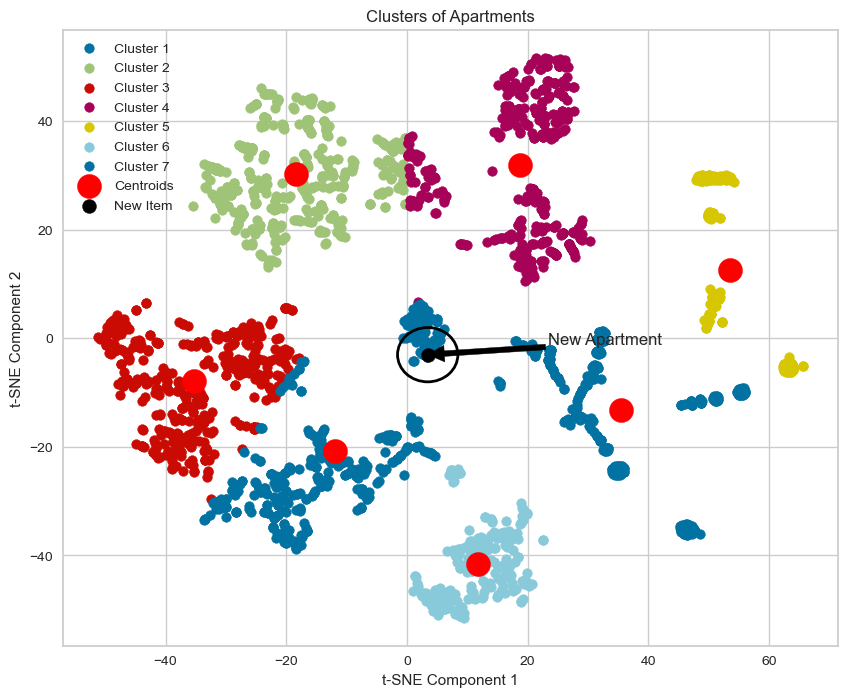

In [23]:
plt.figure(figsize=(10, 8))
for i in range(optimal_clusters):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

# Add the new item to the scatter plot
plt.scatter(new_item_tsne[0], new_item_tsne[1], s=100, c='black', label='New Item')

# Draw a circle around the new item
circle = plt.Circle((new_item_tsne[0], new_item_tsne[1]), 5, color='black', fill=False, linewidth=2)
plt.gca().add_artist(circle)

# Add an arrow pointing to the new item with text
plt.annotate('New Apartment', xy=(new_item_tsne[0], new_item_tsne[1]), xytext=(new_item_tsne[0] + 20, new_item_tsne[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()